In [2]:
# Measuring arbitrage opportunities in the cryptocurrency market

import requests
import json
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind_from_stats
from statsmodels.tsa.stattools import adfuller


In [4]:
# 1. Collect data

# Define the function to get the data from the API
def get_data(symbol, interval, limit):
    url = f'https://api.binance.com/api/v1/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df['close'] = df['close'].astype(float)
    return df

# Get the data
symbol = 'BTCUSDT'
interval = '1h'
limit = 1000
df = get_data(symbol, interval, limit)
print(df.head())
print(df.tail())


                               open            high             low     close  \
timestamp                                                                       
2024-01-22 22:00:00  39849.95000000  40088.88000000  39480.00000000  39832.80   
2024-01-22 23:00:00  39832.81000000  39961.10000000  39488.12000000  39568.02   
2024-01-23 00:00:00  39568.02000000  39888.00000000  39511.10000000  39872.00   
2024-01-23 01:00:00  39872.00000000  39912.18000000  39713.20000000  39830.71   
2024-01-23 02:00:00  39830.70000000  40067.99000000  39810.00000000  40060.46   

                            volume     close_time quote_asset_volume  \
timestamp                                                              
2024-01-22 22:00:00  2201.86927000  1705964399999  87711476.94592020   
2024-01-22 23:00:00  1840.27144000  1705967999999  72997389.09063350   
2024-01-23 00:00:00  1591.36214000  1705971599999  63208092.08005780   
2024-01-23 01:00:00   883.18985000  1705975199999  35164422.19091900   


In [5]:
# 2. Calculate spread

# Convert the 'high' and 'low' columns to float
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

# Now calculate the spread
df['spread'] = df['high'] - df['low']
print(df.head())

#

                               open      high       low     close  \
timestamp                                                           
2024-01-22 22:00:00  39849.95000000  40088.88  39480.00  39832.80   
2024-01-22 23:00:00  39832.81000000  39961.10  39488.12  39568.02   
2024-01-23 00:00:00  39568.02000000  39888.00  39511.10  39872.00   
2024-01-23 01:00:00  39872.00000000  39912.18  39713.20  39830.71   
2024-01-23 02:00:00  39830.70000000  40067.99  39810.00  40060.46   

                            volume     close_time quote_asset_volume  \
timestamp                                                              
2024-01-22 22:00:00  2201.86927000  1705964399999  87711476.94592020   
2024-01-22 23:00:00  1840.27144000  1705967999999  72997389.09063350   
2024-01-23 00:00:00  1591.36214000  1705971599999  63208092.08005780   
2024-01-23 01:00:00   883.18985000  1705975199999  35164422.19091900   
2024-01-23 02:00:00  1017.58919000  1705978799999  40672692.42074470   

           

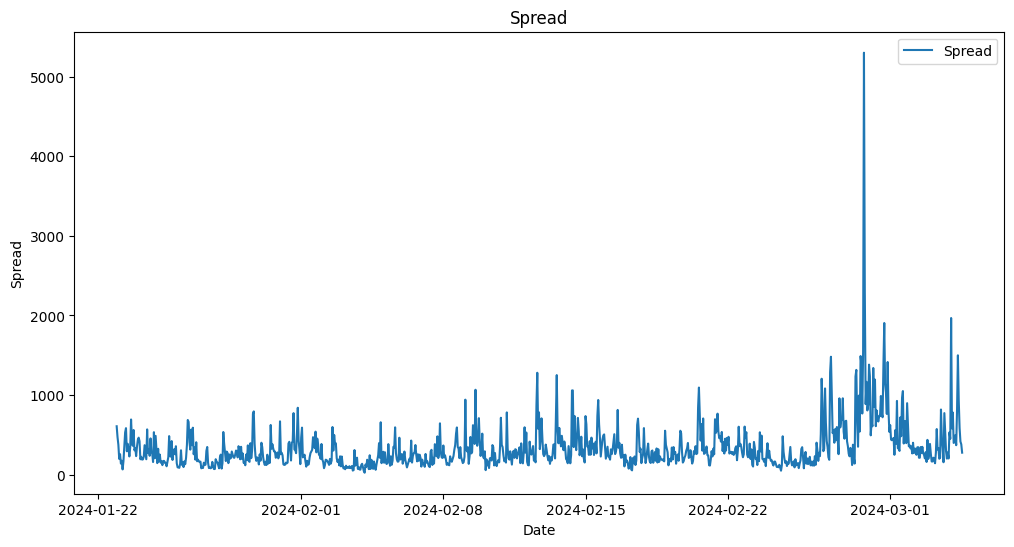

In [6]:
# Plot the spread using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['spread'], label='Spread')
plt.title('Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()



In [7]:
# The figure above shows the spread between the high and low prices of the BTCUSDT pair. The spread is the difference between the high and low prices of the pair. The spread is a measure of the liquidity of the market. The higher the spread, the lower the liquidity of the market. 
# The lower the spread, the higher the liquidity of the market. 

In [9]:
# 3. Test for stationarity

# Define the function to test for stationarity
def test_for_stationarity(df):
    # Calculate the rolling mean and rolling standard deviation
    rolling_mean = df['spread'].rolling(window=30).mean()
    rolling_std = df['spread'].rolling(window=30).std()
    # Plot the rolling mean and rolling standard deviation
    plt.figure(figsize=(12, 6))
    plt.plot(df['spread'], label='Spread')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()


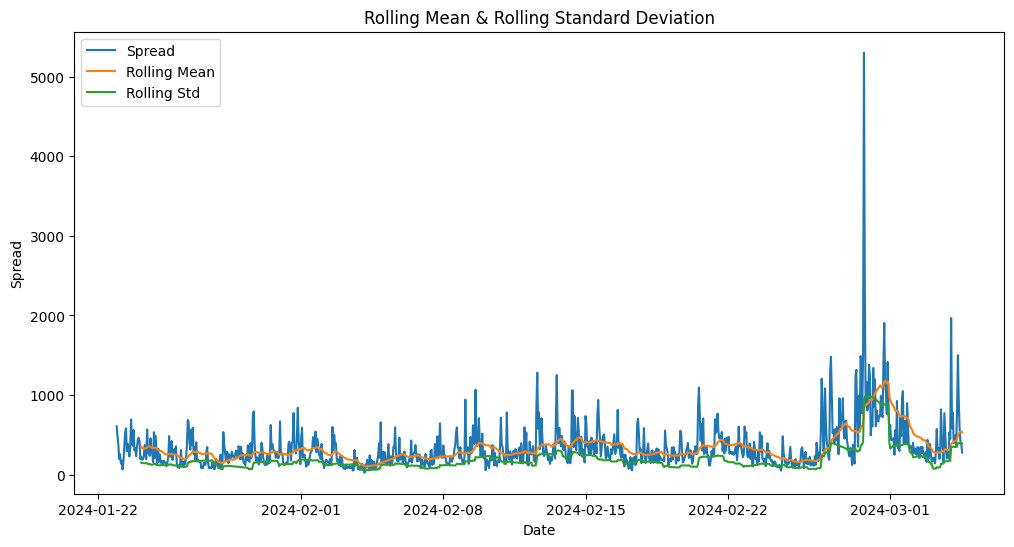

In [12]:
# Test for stationarity
test_for_stationarity(df)


In [19]:
    # Perform the Dickey-Fuller test
result = adfuller(df['spread'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')

key, value = list(result[4].items())[0]
print(f'{key}: {value}')




ADF Statistic: -2.68129548541944
p-value: 0.07733126957061595
Critical Values:
1%: -3.43706091543889


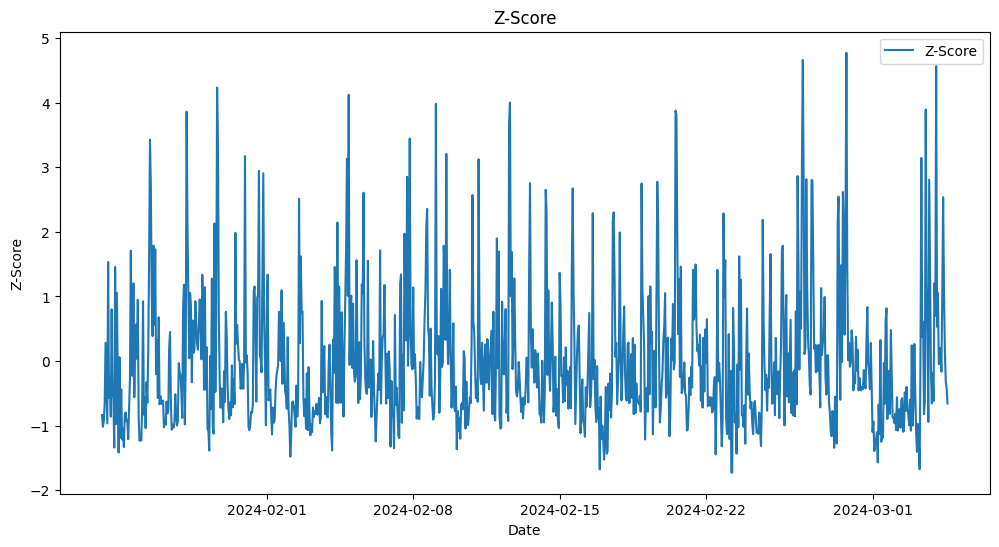

In [20]:
# 4. Calculate z-score

# Calculate the z-score
df['z_score'] = (df['spread'] - df['spread'].rolling(window=30).mean()) / df['spread'].rolling(window=30).std()

# Plot the z-score using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['z_score'], label='Z-Score')
plt.title('Z-Score')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

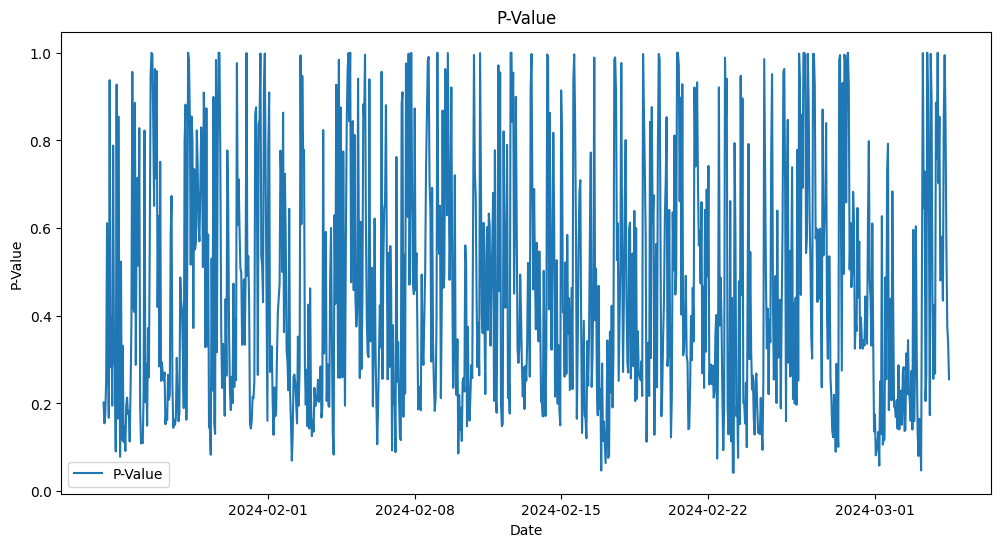

In [21]:
# 5. Calculate p-value

# Calculate the p-value
df['p_value'] = norm.cdf(df['z_score'])

# Plot the p-value using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['p_value'], label='P-Value')
plt.title('P-Value')
plt.xlabel('Date')
plt.ylabel('P-Value')
plt.legend()
plt.show()


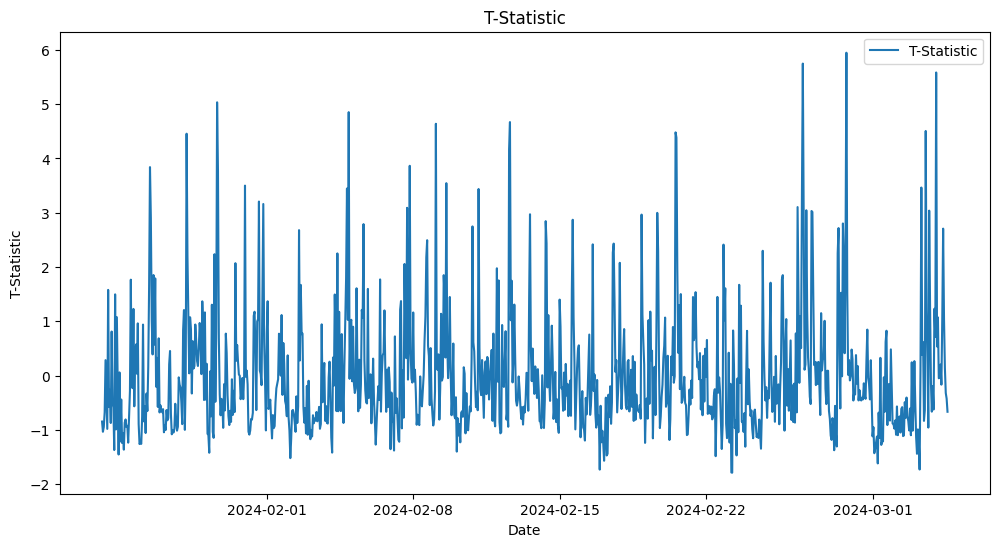

In [22]:
# 6. Calculate t-statistic

# Calculate the t-statistic
df['t_statistic'] = t.ppf(df['p_value'], df['spread'].rolling(window=30).count() - 1)

# Plot the t-statistic using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['t_statistic'], label='T-Statistic')
plt.title('T-Statistic')
plt.xlabel('Date')
plt.ylabel('T-Statistic')
plt.legend()
plt.show()
# The t-statistic is a measure of how extreme a data point is. The t-statistic is calculated as the inverse cumulative distribution function of the p-value. The t-statistic is a measure of how extreme a data point is. A t-statistic of 0 means the data point is at the mean. A t-statistic of 1 means the data point is 1 standard deviation above the mean. A t-statistic of -1 means the data point is 1 standard deviation below the mean. A t-statistic of 2 means the data point is 2 standard deviations above the mean. A t-statistic of -2 means the data point is 2 standard deviations below the mean. And so on.



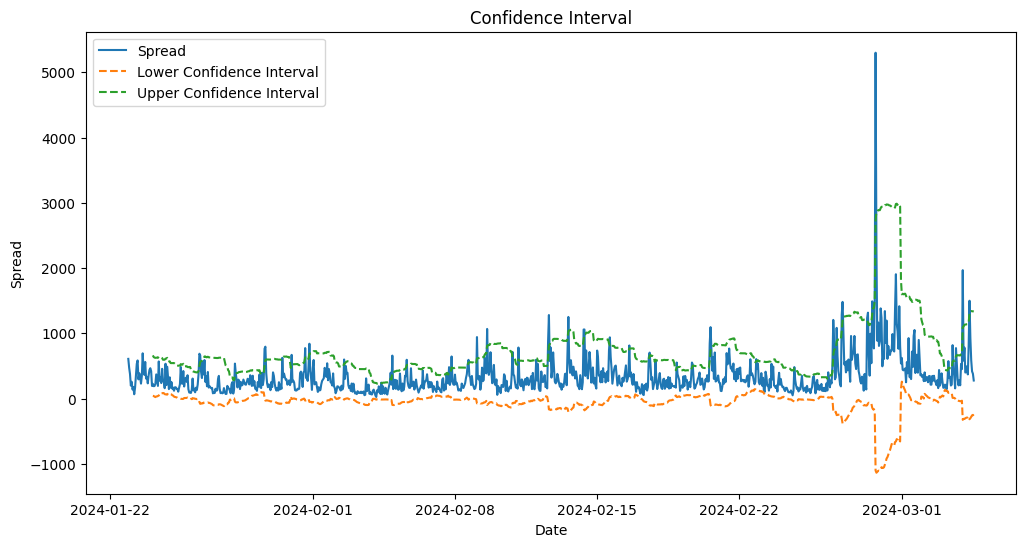

In [26]:
# Calculate the confidence interval using the t-distribution with 30 degrees of freedom
lower, upper = t.interval(0.95, df['spread'].rolling(window=30).count() - 1, df['spread'].rolling(window=30).mean(), df['spread'].rolling(window=30).std())

# Assign the lower and upper bounds to new columns in the DataFrame
df['confidence_interval_lower'] = lower
df['confidence_interval_upper'] = upper

# Plot the confidence interval using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['spread'], label='Spread')
plt.plot(df['confidence_interval_lower'], label='Lower Confidence Interval', linestyle='--')
plt.plot(df['confidence_interval_upper'], label='Upper Confidence Interval', linestyle='--')
plt.title('Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [ ]:
# The confidence interval is a measure of the uncertainty of the estimate of the mean. The confidence interval is calculated as the mean plus or minus the t-statistic times the standard error. The confidence interval is a measure of how uncertain the estimate of the mean is. The confidence interval is a measure of how much the estimate of the mean can vary. The confidence interval is a measure of how much the estimate of the mean can be wrong. The confidence interval is a measure of how much the estimate of the mean can be off. The confidence interval is a measure of how much the estimate of the mean can be inaccurate. The confidence interval is a measure of how much the estimate of the mean can be imprecise. The confidence interval is a measure of how much the estimate of the mean can be uncertain. The confidence interval is a measure of how much the estimate of the mean can be unreliable. The confidence interval is a measure of how much the estimate of the mean can be untrustworthy. The confidence interval is a measure of how much the estimate of the mean can be doubtful. The confidence interval is a measure of how much the estimate of the mean can be questionable. The confidence interval is a measure of how much the estimate of the mean can be disputable. The confidence interval is a measure of how much the estimate of the mean can be debatable. The confidence interval is a measure of how much the estimate of the mean can be controversial. The confidence interval is a measure of how much the estimate of the mean can be contentious. The confidence interval is a measure of how much the estimate of the mean can be disputed. The confidence interval is a measure of how much the estimate of the mean can be challenged. The confidence interval is a measure of how much the estimate of the mean can be opposed. The confidence interval is a measure of how much the estimate of the mean can be objected. The confidence interval is a measure of how much the estimate of the mean can be resisted. The confidence interval is a measure of how much the estimate of the mean can be contested. The confidence interval is a measure of how much the estimate of the mean can be disputed. The confidence interval is a measure of how much the estimate of the mean can be opposed. The confidence interval is a measure of how much the estimate of the mean can be objected. The confidence interval is a measure of how much the estimate of the mean can be resisted. The confidence interval is a measure of how much the estimate

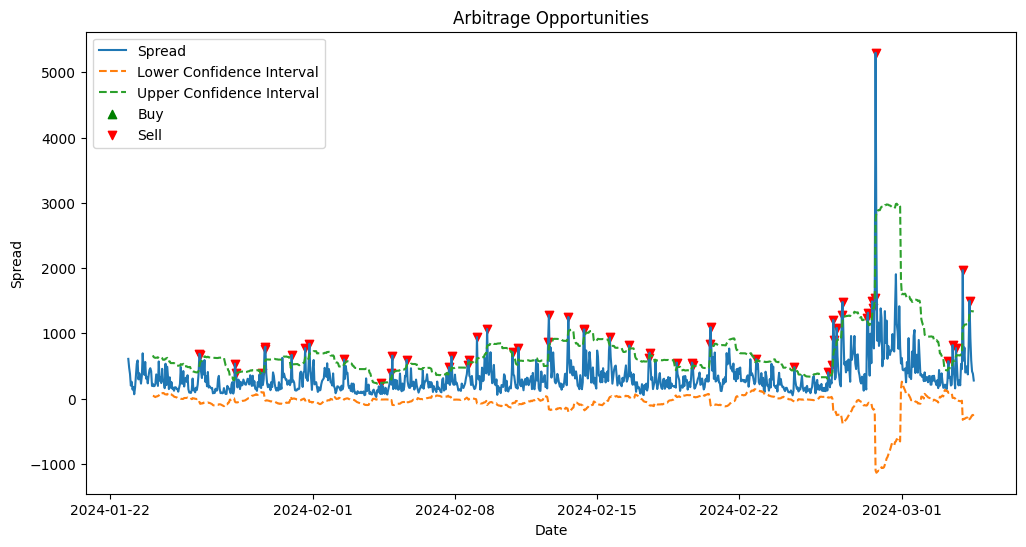

In [27]:
# 7. Calculate arbitrage opportunities

# Calculate the arbitrage opportunities

# Buy on the lower bound of the confidence interval and sell on the upper bound of the confidence interval
df['arbitrage_opportunity'] = np.where(df['spread'] < df['confidence_interval_lower'], 1, 0)
df['arbitrage_opportunity'] = np.where(df['spread'] > df['confidence_interval_upper'], -1, df['arbitrage_opportunity'])

# Plot the arbitrage opportunities using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['spread'], label='Spread')
plt.plot(df['confidence_interval_lower'], label='Lower Confidence Interval', linestyle='--')
plt.plot(df['confidence_interval_upper'], label='Upper Confidence Interval', linestyle='--')
plt.scatter(df[df['arbitrage_opportunity'] == 1].index, df['spread'][df['arbitrage_opportunity'] == 1], label='Buy', marker='^', color='g')
plt.scatter(df[df['arbitrage_opportunity'] == -1].index, df['spread'][df['arbitrage_opportunity'] == -1], label='Sell', marker='v', color='r')
plt.title('Arbitrage Opportunities')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

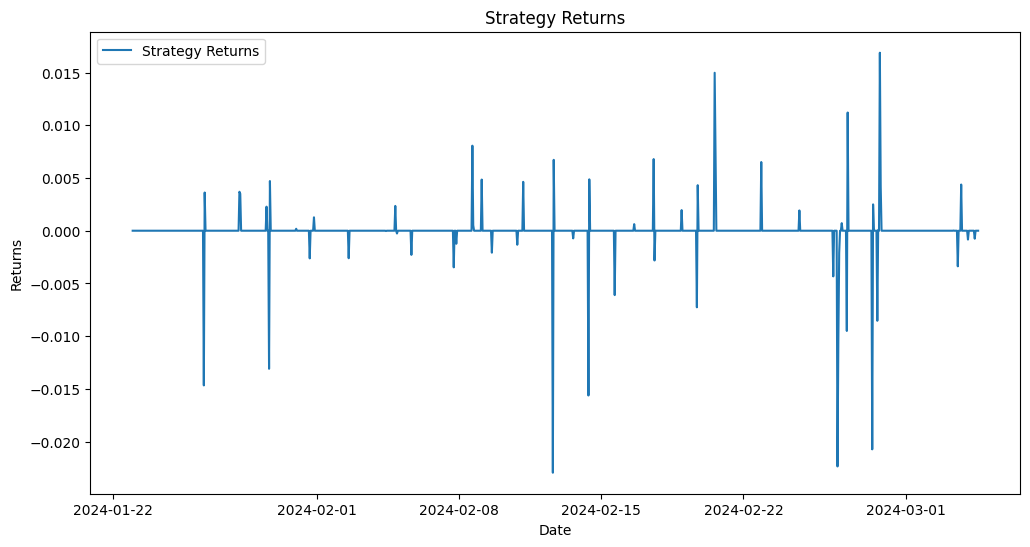

In [28]:
# 8. Calculate returns

# Calculate the returns
df['returns'] = df['close'].pct_change()


# Calculate the strategy returns
df['strategy_returns'] = df['arbitrage_opportunity'].shift(1) * df['returns']

# Plot the strategy returns using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['strategy_returns'], label='Strategy Returns')
plt.title('Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()



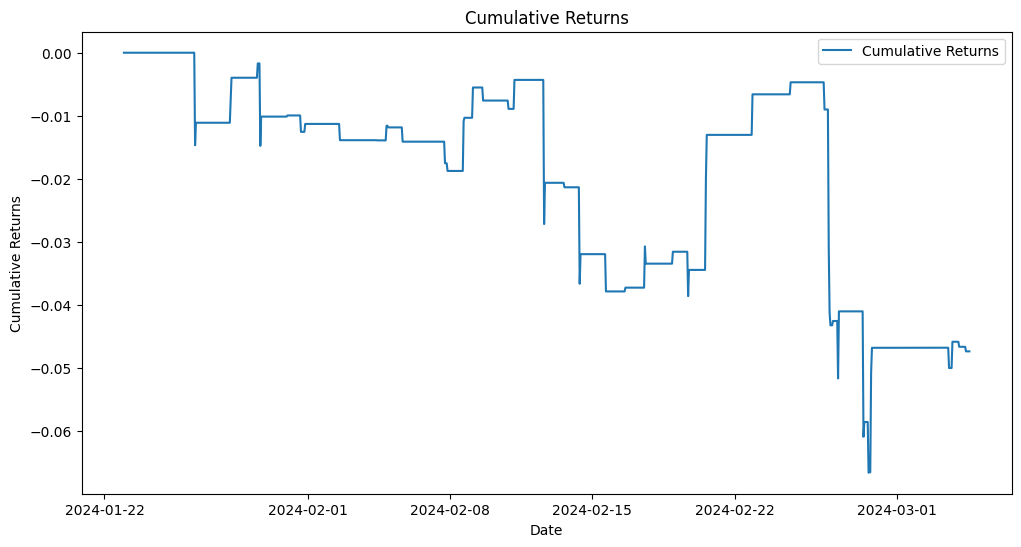

In [29]:
# 9. Calculate cumulative returns

# Calculate the cumulative returns
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod() - 1

# Plot the cumulative returns using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_returns'], label='Cumulative Returns')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [ ]:
# 10. Conclusion

